In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import time
import math
from numba import jit

%matplotlib notebook

## Simulated data for block trial structure

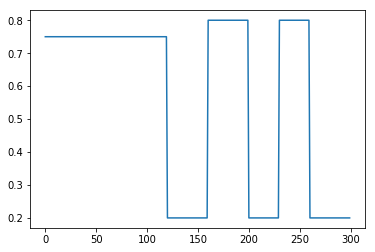

In [2]:
# Generate fake data from the model
# Build the true reward rate
true_prob = [0.75] * 120 + [0.2] * 40 + [0.8] * 40 + [0.2] * 30 + [0.8] * 30 + [0.2] * 40
plt.plot(true_prob)

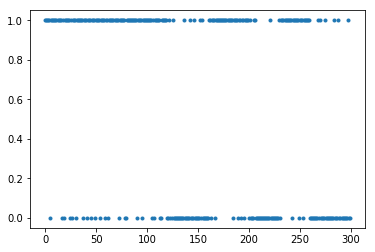

In [3]:
# Generate data from bernoulli
randvars = np.random.random(len(true_prob))
outcomes = randvars < true_prob
plt.figure()
plt.plot(outcomes, '.')

## Exact inference

In [37]:
a = 0.5
my_beta(a, 2, 2)

1.5

In [34]:
# Define some conditionals that will be useful
@jit(nopython=True)
def my_beta(x, a, b):
    constant = math.gamma(a + b) / math.gamma(a) / math.gamma(b)
    return constant * x**(a - 1) * (1 - x)**(b - 1)


@jit
def pr_next(rnext, rprev, v):
    '''Find p(r_{i+1} = rnext | r_i = rprev, v)'''
    # Take care of boundaries:
    if rnext == 0:
        rval = 1e-10
    elif rnext == 1:
        rval = 1 - 1e-10
    else:
        rval = rnext
                  
    s = rprev * np.exp(-v)
    n = (1 - rprev) * np.exp(-v)
    
    if s == 0:
        s = 1e-10
    if n == 0:
        n = 1e-10
    
    #print(s, n)
    return sts.beta.pdf(rval, s, n)

@jit
def pv_next(vnext, vprev, k):
    '''Find p(v_{i+1} = vnext | v_i = vprev, k)'''
    K = np.exp(k)
    return sts.norm.pdf(vnext, vprev, K)

@jit
def py_given_r(y, r):
    '''p(y = y| r), which is bernoulli'''
    if y == 1:
        return r
    else:
        return 1 - r

In [5]:
# Set up a grid of r, v, k
rvals = np.linspace(0, 1, 10)
vvals = np.linspace(-10, 0, 10)
kvals = np.linspace(-10, 0, 10)
rgrid, vgrid, kgrid = np.meshgrid(rvals, vvals, kvals, indexing='ij')

#print(r, v, k, i)
dv = vvals[1] - vvals[0]
dr = rvals[1] - rvals[0]


# Set up the probability grid
posterior_arr = np.ones_like(rgrid)

In [25]:
# Use recursion to find the posterior
@jit
def find_posterior(r, v, k, y, i):
    '''Find the posterior p(r_{i+1}, v_{i+1}, k | y_{<=i+1})
    Inputs:
    - r: value of r_{i+1}
    - v: value of v_{i+1}
    - k: value of k
    - y: array of y responses
    - i: time point'''
    
    #print(r, v, k, i)
    dv = (np.max(vvals) - np.min(vvals)) / len(vvals)
    dr = (np.max(rvals) - np.min(rvals)) / len(rvals)
    # Base case
    if i == -1:
        return 1 # Uniform prior
    
    # Recursive step
    p_yr = py_given_r(y[i], r)
    
    # Do the integral
    integral = 0
    for ri in rvals:
        p_rv = pr_next(r, ri, v)
        #print('p_rv:', r, ri, v, p_rv)
        
        # Inner integral
        inner = 0
        for vi in vvals:
            p_vk = pv_next(v, vi, k)
            posterior_prev = find_posterior(ri, vi, k, y, i - 1)
            inner += posterior_prev * p_vk * dv
    
        integral += inner * p_rv * dr
        
    #print('Results for ', r, v, k, i, ': ', integral)
    return integral * p_yr
    

In [26]:
# Use recursion to find the posterior
@jit
def find_posterior_fast(nr, nv, nk, y, i, results):
    '''Find the posterior p(r_{i+1}, v_{i+1}, k | y_{<=i+1})
    Inputs:
    - r: value of r_{i+1}
    - v: value of v_{i+1}
    - k: value of k
    - y: array of y responses
    - i: time point'''
    
    # Check if answer is in results
    if results[nr][nv][nk][i] >= 0:
        return results[nr][nv][nk][i]
    
    else:
        # Base case
        if i == -1:
            results[nr][nv][nk][i] = 1
            return 1 # Uniform prior

        # Recursive step
        r = rvals[nr]
        k = kvals[nk]
        v = vvals[nv]
        
        p_yr = py_given_r(y[i], r)

        # Do the integral
        integral = 0
        for nri, ri in enumerate(rvals):
            p_rv = pr_next(r, ri, v)
            #print('p_rv:', r, ri, v, p_rv)

            # Inner integral
            inner = 0
            for nvi, vi in enumerate(vvals):
                p_vk = pv_next(v, vi, k)
                posterior_prev = find_posterior_fast(nri, nvi, nk, y, i - 1, results)
                inner += posterior_prev * p_vk * dv

            integral += inner * p_rv * dr
        
        results[nr][nv][nk][i] = integral * p_yr
        #print('Results for ', r, v, k, i, ': ', integral)
        return integral * p_yr
    

In [27]:
results = np.ones((len(rvals), len(vvals), len(kvals), len(outcomes))) * -1

start = time.time()
for t in range(30):
    print(t)
    for ir, r1 in enumerate(rvals):
        for iv, v1 in enumerate(vvals):
            for im, k1 in enumerate(kvals):
                find_posterior_fast(ir, iv, im, outcomes, t, results)
    
    # Normalize 
    results[:,:,:,t] = results[:,:,:,t] / np.sum(results[:,:,:,t])
    
end = time.time()
print('Elapsed time is ', end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Elapsed time is  237.33182215690613


<IPython.core.display.Javascript object>


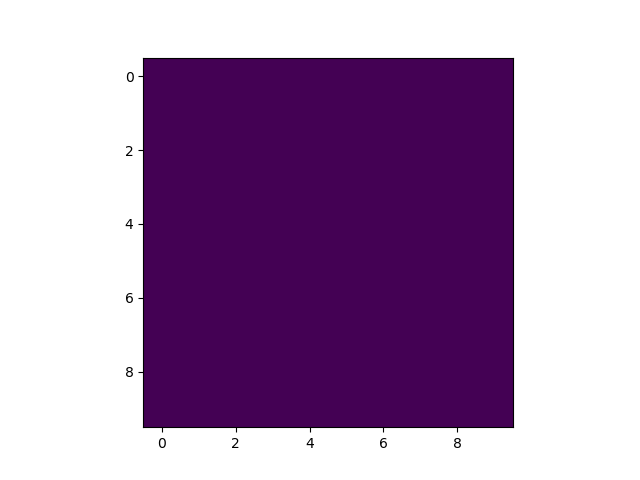

In [28]:
plt.figure()
plt.imshow(results[3,:,:,49])

In [192]:
firsti = results[0,:,:,49]
np.sum(firsti)

5.1741116386661286e+19

In [200]:
np.sum(i_prob / np.sum(i_prob) * rvals)

0.5338349830764292

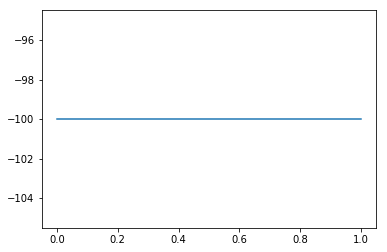

In [9]:
endres = results[:,:,:,49]
# Marginalize out v and k
i_prob = np.sum(endres, axis=(0,1))
i_prob / np.sum(i_prob)
plt.figure()
plt.plot(rvals,i_prob)

## Evolution of the parameters

In [29]:
rprobs = []
vprobs = []
kprobs = []

for t in range(30):
    endres = results[:,:,:,t]
    # Marginalize out v and k
    r_prob = np.sum(endres, axis=(1,2))
    v_prob = np.sum(endres, axis=(0,2))
    k_prob = np.sum(endres, axis=(0,1))
    
    # Expectations
    expR = np.sum(r_prob / np.sum(r_prob) * rvals)
    expV = np.sum(v_prob / np.sum(v_prob) * vvals)
    expK = np.sum(k_prob / np.sum(k_prob) * kvals)
    
    rprobs.append(expR)
    vprobs.append(expV)
    kprobs.append(expK)
    

<IPython.core.display.Javascript object>


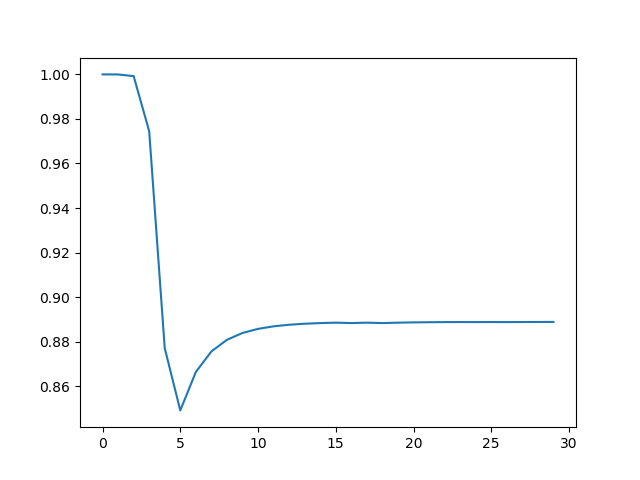

In [31]:
plt.figure()
plt.plot(rprobs)
#plt.plot(true_prob)

In [203]:
expR

0.5338349830764292

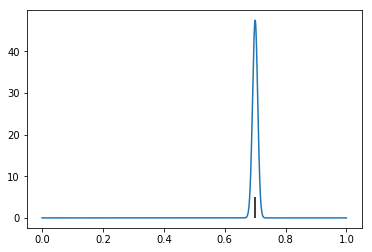

In [28]:
ri = 0.7
xvals = np.linspace(0,1,1000)
probs = sts.beta.pdf(xvals, ri * np.exp(8), (1 - ri) * np.exp(8))

plt.figure()
plt.plot(xvals, probs)
plt.vlines(0.7, ymin=0, ymax=5)

In [23]:
-np.log(100)

-4.605170185988092